In [1]:
import numpy as np
from scipy.special import hankel2
from examples.seismic.acoustic import AcousticWaveSolver
from examples.seismic import Model, RickerSource, Receiver
from devito import clear_cache, set_log_level
from opescibench import LinePlotter

import matplotlib.pyplot as plt
from matplotlib import cm

In [2]:
# Model with fixed time step value
class ModelBench(Model):
    """
    Physical model used for accuracy benchmarking.
    The critical dt is made small enough to ignore
    time discretization errors
    """

    @property
    def critical_dt(self):
        """Critical computational time step value."""
        return .1

# Verification

We compute the error between the numerical and reference solutions for varying spatial discretization order and grid spacing. We also compare the time to solution to the error for these parameters.

In [3]:
# Discretization order
orders = (2, 4, 6, 8, 10)
norder = len(orders)

# Domain sizes and gird spacing
shapes = ((201, 2.0), (161, 2.5), (101, 4.0))
dx = [2.0, 2.5, 4.0]
nshapes = len(shapes)

# Number of time steps
nt = 1501
# Time axis
time = np.linspace(0., 150., nt)
# Source peak frequency
f0 = .06

In [4]:
# Fine grid model
c0 = 1.5
model = ModelBench(vp=c0, origin=(0., 0.), spacing=(.5, .5), shape=(801, 801), nbpml=40, dtype=np.float64)

In [5]:
# Source and receiver
src = RickerSource(name='src', grid=model.grid, f0=f0, time=time)
src.coordinates.data[0, :] = np.array(model.domain_size) * .5
src.data[:] = 1e2*src.data[:] / (.5*c0)**2
# Define receiver geometry (spread across x, just below surface)
rec = Receiver(name='rec', grid=model.grid, ntime=nt, npoint=1)
rec.coordinates.data[:, 0] = 260.
rec.coordinates.data[:, 1] = 260.

# Reference solution for numerical convergence

In [6]:
solver = AcousticWaveSolver(model, source=src, receiver=rec, time_order=2, space_order=20)

ref_rec, ref_u, _ = solver.forward()

GNUCompiler: compiled /var/folders/mx/qs0dn9rx7zn6dz2zvwv7tkk00000gn/T/devito-uselahbo/7261032ccc57ff87dc245bd04b59bcf3be82b92b.c [1.19 s]
Section section_1<1499,1> with OI=0.62 computed in 0.002 s [0.04 GFlops/s]
Section section_2<1499,1> with OI=0.77 computed in 0.068 s [0.00 GFlops/s]
Section main<1499,861,861> with OI=2.86 computed in 11.997 s [6.67 GFlops/s, 0.09 GPts/s]


# Analytical solution for comparison with the reference numerical solution

The analytical solution of the 2D acoustic wave-equation with a source pulse is defined as:

$$
u_s(r, t) = \frac{1}{2\pi} \int_{-\infty}^{\infty} \{ -i \pi H_0^{(2)}\left(k r \right) q(\omega) e^{i\omega t} d\omega\}
$$

$$
r = \sqrt{(x - x_{src})^2+(y - y_{src})^2}
$$

where $H_0^{(2)}$ is the Hankel function of the second kind, $F(\omega)$ is the Fourier spectrum of the source time function at angular frequencies $\omega$ and $k = \frac{\omega}{v}$ is the wavenumber.

We look at the analytical and numerical solution at a single grid point. We ensure that this grid point is on-the-grid for all discretizations analyised in the further verification.

In [7]:
# Source and receiver coordinates
sx, sz = src.coordinates.data[0, :]
rx, rz = rec.coordinates.data[0, :]

# Define an Ricker wavelet shifted to zero lag for the Fourier transform
def ricker(f, T, dt, t0):
    t = np.linspace(-t0, T-t0, int(T/dt))
    tt = (np.pi**2) * (f**2) * (t**2)
    y = 1e2*(1.0 - 2.0 * tt) * np.exp(- tt)
    return y

def analytical(nt, model, time, **kwargs):
    dt = kwargs.get('dt', model.critical_dt)
    # Fourier constants
    nf = int(nt/2 + 1)
    fnyq = 1. / (2 * dt)
    df = 1.0 / time[-1]
    faxis = df * np.arange(nf)

    rick= ricker(f0, time[-1], dt, 1.0/f0)

    # Take the FOurier transform ofthe source time-function
    R = np.fft.fft(rick/(c0**2))
    R = R[0:nf]
    nf = len(R)

    # Compute the Hankel function and multiply by the source spectrum
    U_a = np.zeros((nf), dtype=complex)
    for a in range(1, nf-1):
        k = 2 * np.pi * faxis[a] / c0
        tmp = k * np.sqrt(((rx - sx))**2 + ((rz - sz))**2)
        U_a[a] = -1j * np.pi * hankel2(0.0, tmp) * R[a]

    # Do inverse fft on 0:dt:T and you have analytical solution
    U_t = 1.0/(2.0 * np.pi) * np.real(np.fft.ifft(U_a[:], nt))
    return np.real(U_t)

In [8]:
time1 = np.linspace(0.0, 3000., 30001)
U_t = analytical(30001, model, time1, dt=time1[1] - time1[0])
U_t = U_t[0:1501]

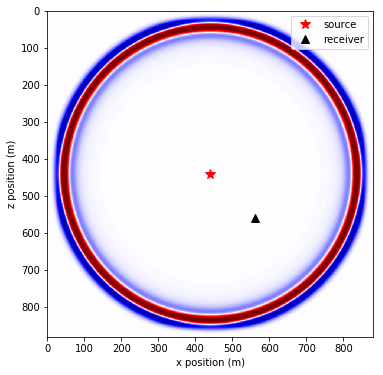

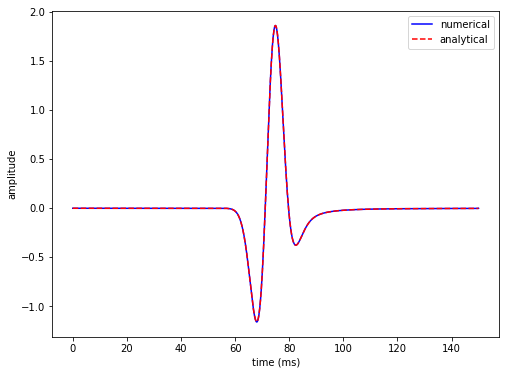

In [9]:

# Plot wavefield and source/rec position
plt.figure()
plt.imshow(ref_u.data[1,:,:], vmin=-1., vmax=1., cmap="seismic")
plt.plot(2*sx+40, 2*sz+40, 'r*', markersize=11, label='source') # plot position of the source in model, add nbpml for correct position
plt.plot(2*rx+40, 2*rz+40, 'k^', markersize=8, label='receiver')  # plot position of the receiver in model, add nbpml for correct position
plt.legend()
plt.xlabel('x position (m)')
plt.ylabel('z position (m)')
plt.savefig('wavefieldperf.pdf')

# Plot trace
plt.figure()
plt.plot(time, ref_rec.data[:, 0], '-b', label='numerical')
plt.plot(time, U_t[:], '--r', label='analytical')
plt.xlabel('time (ms)')
plt.ylabel('amplitude')
plt.legend()
plt.savefig('ref.pdf')
plt.show()

In [10]:
error_time = np.zeros(5)
error_time[0] = np.linalg.norm(U_t[:-1] - ref_rec.data[:-1, 0], 2)/np.sqrt(nt)
print(error_time[0])

0.000990784254912


# Convergence in time


We first show the convergence of the time discretization for a fix high-order spatial discretization (20th order).

After we show that the time discretization converges in $O(dt^2)$ and therefore only contains the error in time, we will take the numerical solution for `dt=.1ms` as a reference for the spatial discretization analysis.



In [11]:
dt = [.1, 0.08, .075, 0.0625, .05]
nnt = [1501, 1876, 2001, 2401, 3001]

for i in range(1, 5):
    # Time axis
    time = np.linspace(0., 150., nnt[i])
    # Source and receiver
    src = RickerSource(name='src', grid=model.grid, f0=f0, time=time)
    src.coordinates.data[0, :] = np.array(model.domain_size) * .5
    src.data[:] = 100.0 * src.data[:] / (.5*c0)**2
    # Define receiver geometry (spread across x, just below surface)
    rec = Receiver(name='rec', grid=model.grid, ntime=nnt[i], npoint=1)
    rec.coordinates.data[:, 0] = 260.
    rec.coordinates.data[:, 1] = 260.
    solver = AcousticWaveSolver(model, source=src, receiver=rec, time_order=2, space_order=20)
    ref_rec1, ref_u1, _ = solver.forward(dt=dt[i])
    
    time1 = np.linspace(0.0, 3000., 20*(nnt[i]-1) + 1)
    U_t1 = analytical(20*(nnt[i]-1) + 1, model, time1, dt=time1[1] - time1[0])
    U_t1 = U_t1[0:nnt[i]]
    error_time[i] = np.linalg.norm(U_t1[:-1] - ref_rec1.data[:-1, 0], 2)/np.sqrt(nnt[i])
    print("error for dt= %s is %s \n" % (dt[i], error_time[i]))

GNUCompiler: compiled /var/folders/mx/qs0dn9rx7zn6dz2zvwv7tkk00000gn/T/devito-uselahbo/7261032ccc57ff87dc245bd04b59bcf3be82b92b.c [0.55 s]
Section section_1<1874,1> with OI=0.62 computed in 0.003 s [0.04 GFlops/s]
Section section_2<1874,1> with OI=0.77 computed in 0.084 s [0.00 GFlops/s]
Section main<1874,861,861> with OI=2.86 computed in 15.268 s [6.55 GFlops/s, 0.09 GPts/s]


error for dt= 0.08 is 0.000661270695888 



GNUCompiler: compiled /var/folders/mx/qs0dn9rx7zn6dz2zvwv7tkk00000gn/T/devito-uselahbo/7261032ccc57ff87dc245bd04b59bcf3be82b92b.c [1.45 s]
Section section_1<1999,1> with OI=0.62 computed in 0.002 s [0.04 GFlops/s]
Section section_2<1999,1> with OI=0.77 computed in 0.089 s [0.00 GFlops/s]
Section main<1999,861,861> with OI=2.86 computed in 15.497 s [6.88 GFlops/s, 0.10 GPts/s]


error for dt= 0.075 is 0.000589039807389 



GNUCompiler: compiled /var/folders/mx/qs0dn9rx7zn6dz2zvwv7tkk00000gn/T/devito-uselahbo/7261032ccc57ff87dc245bd04b59bcf3be82b92b.c [1.27 s]
Section section_1<2399,1> with OI=0.62 computed in 0.003 s [0.04 GFlops/s]
Section section_2<2399,1> with OI=0.77 computed in 0.112 s [0.00 GFlops/s]
Section main<2399,861,861> with OI=2.86 computed in 18.454 s [6.94 GFlops/s, 0.10 GPts/s]


error for dt= 0.0625 is 0.000425008658919 



GNUCompiler: compiled /var/folders/mx/qs0dn9rx7zn6dz2zvwv7tkk00000gn/T/devito-uselahbo/7261032ccc57ff87dc245bd04b59bcf3be82b92b.c [0.75 s]
Section section_1<2999,1> with OI=0.62 computed in 0.004 s [0.04 GFlops/s]
Section section_2<2999,1> with OI=0.77 computed in 0.127 s [0.00 GFlops/s]
Section main<2999,861,861> with OI=2.86 computed in 23.356 s [6.85 GFlops/s, 0.10 GPts/s]


error for dt= 0.05 is 0.000286225142865 



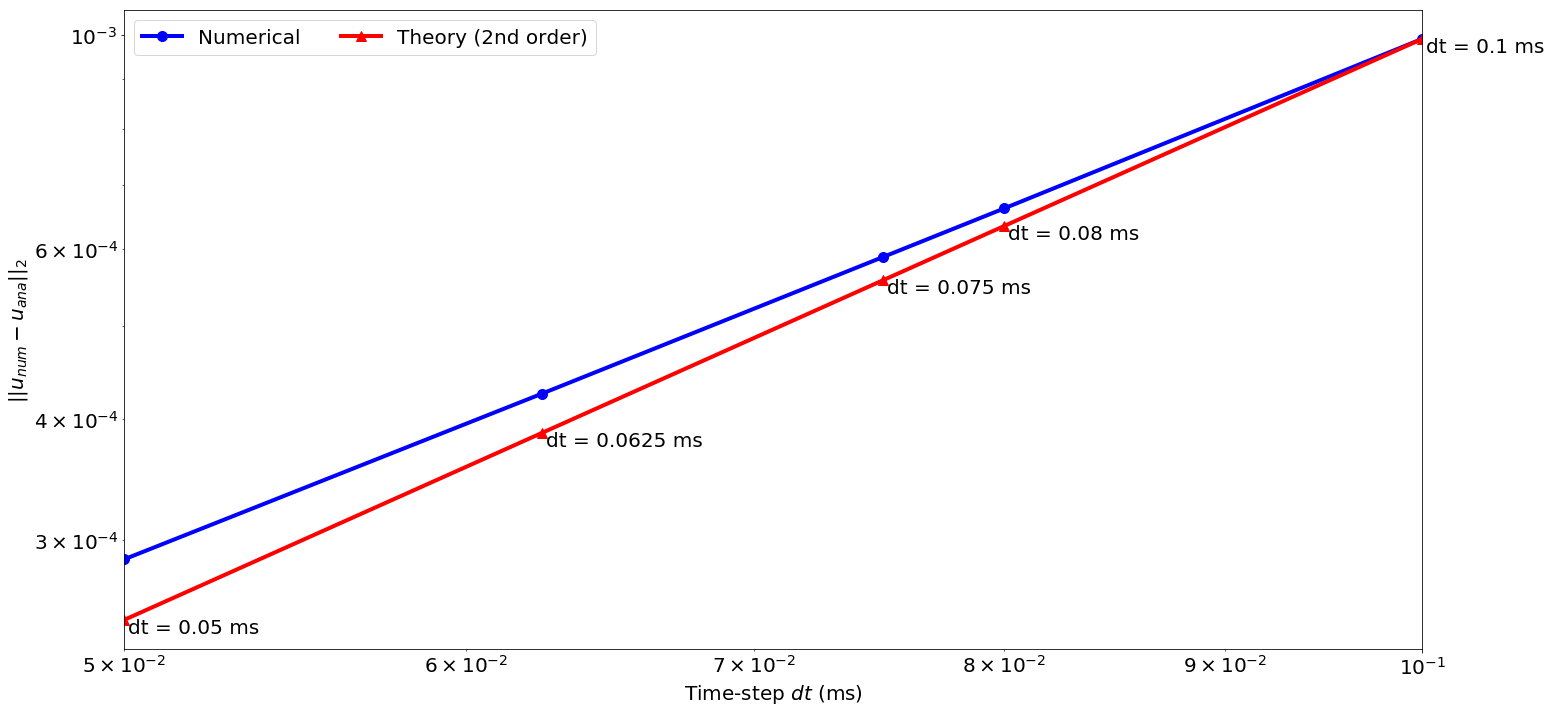

In [12]:
dt = [.1, 0.08, .075, 0.0625, .05]

plt.figure(figsize=(20, 10))
theory = [t**2 for t in dt]
theory = [error_time[0]*th/theory[0] for th in theory]
plt.loglog([t for t in dt], error_time, '-ob', label=('Numerical'), linewidth=4, markersize=10)
plt.loglog([t for t in dt], theory, '-^r', label=('Theory (2nd order)'), linewidth=4, markersize=10)
for x, y, a in zip([t for t in dt], theory, [('dt = %s ms' % (t)) for t in dt]):
            plt.annotate(a, xy=(x, y), xytext=(4, 2),
                         textcoords='offset points', size=20,
                         horizontalalignment='left', verticalalignment='top')
plt.xlabel("Time-step $dt$ (ms)", fontsize=20)
plt.ylabel("$|| u_{num} - u_{ana}||_2$", fontsize=20)
plt.tick_params(axis='both', which='both', labelsize=20)
plt.tight_layout()
plt.xlim((0.05, 0.1))
plt.legend(fontsize=20, ncol=4, fancybox=True, loc='best')
plt.savefig("TimeConvergence.pdf", format='pdf', facecolor='white',
            orientation='landscape', bbox_inches='tight')
plt.show()

In [13]:
np.polyfit(np.log([t for t in dt]), np.log(error_time), deg=1)

array([ 1.79092866, -2.79614204])

# Convergence in space
We have a correct refernce solution we can use for space discretization analysis

In [23]:
errorl2 = np.zeros((norder, nshapes))
timing = np.zeros((norder, nshapes))

set_log_level("ERROR")
ind_o = -1
for spc in orders:
    ind_o +=1
    ind_spc = -1
    for nn, h in shapes:
        ind_spc += 1
        clear_cache()
        time = np.linspace(0., 150., nt)
        model = ModelBench(vp=c0, origin=(0., 0.), spacing=(h, h), shape=(nn, nn),
                           nbpml=40, dtype=np.float64)
        src = RickerSource(name='src', grid=model.grid, f0=f0, time=time)
        src.coordinates.data[0, :] = 200.
        src.data[:] = 100. * src.data[:] / (c0*h)**2

        # Define receiver geometry
        rec = Receiver(name='rec', grid=model.grid, ntime=nt, npoint=1)
        rec.coordinates.data[:, 0] = 260.
        rec.coordinates.data[:, 1] = 260.
        solver = AcousticWaveSolver(model, source=src, receiver=rec, time_order=2, space_order=spc)

        loc_rec, loc_u, summary = solver.forward()
        # Compare to reference solution
        errorl2[ind_o, ind_spc] = np.linalg.norm(loc_rec.data[:] - ref_rec.data[:], np.inf)
        timing[ind_o, ind_spc] = summary.timings['main']
        print("starting space order %s with (%s, %s) grid points the error is %s for %s seconds runtime" %
              (spc, nn, nn, errorl2[ind_o, ind_spc], timing[ind_o, ind_spc]))
        
        
        

starting space order 2 with (201, 201) grid points the error is 0.405509388154 for 0.68421 seconds runtime
starting space order 2 with (161, 161) grid points the error is 0.662937686195 for 0.543761 seconds runtime
starting space order 2 with (101, 101) grid points the error is 1.5216010107 for 0.31523 seconds runtime
starting space order 4 with (201, 201) grid points the error is 0.0182877445697 for 0.699546 seconds runtime
starting space order 4 with (161, 161) grid points the error is 0.0454744484444 for 0.538744 seconds runtime
starting space order 4 with (101, 101) grid points the error is 0.316689029767 for 0.364237 seconds runtime
starting space order 6 with (201, 201) grid points the error is 0.0015273919349 for 0.614536 seconds runtime
starting space order 6 with (161, 161) grid points the error is 0.0055105121313 for 0.503188 seconds runtime
starting space order 6 with (101, 101) grid points the error is 0.0872608581089 for 0.234575 seconds runtime
starting space order 8 with

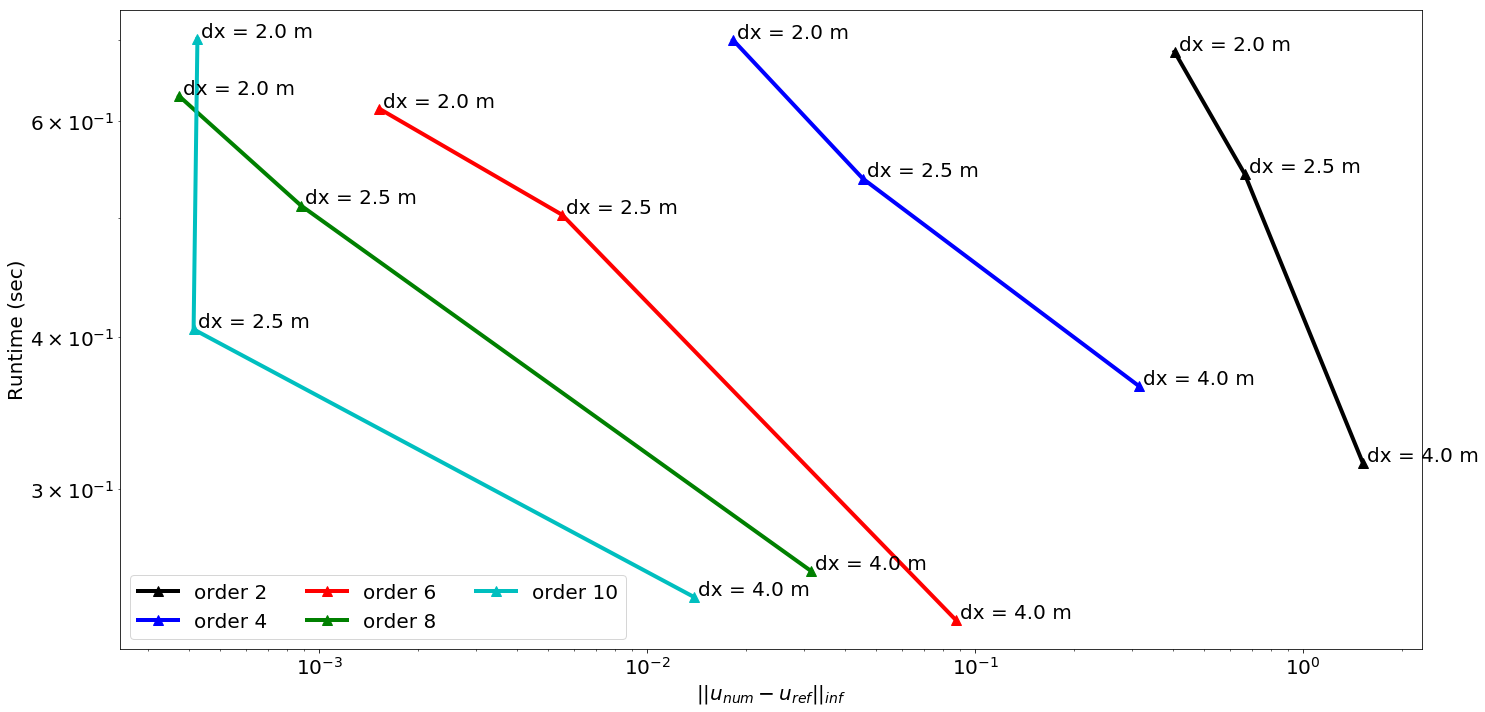

In [24]:
stylel = ('-^k', '-^b', '-^r', '-^g', '-^c')

plt.figure(figsize=(20, 10))
for i in range(0, 5):
    plt.loglog(errorl2[i, :], timing[i, :], stylel[i], label=('order %s' % orders[i]), linewidth=4, markersize=10)
    for x, y, a in zip(errorl2[i, :], timing[i, :], [('dx = %s m' % (sc)) for sc in dx]):
                plt.annotate(a, xy=(x, y), xytext=(4, 2),
                             textcoords='offset points', size=20)
plt.xlabel("$|| u_{num} - u_{ref}||_{inf}$", fontsize=20)
plt.ylabel("Runtime (sec)", fontsize=20)
plt.tick_params(axis='both', which='both', labelsize=20)
plt.tight_layout()
plt.legend(fontsize=20, ncol=3, fancybox=True, loc='best')
plt.savefig("TimeAccuracy.pdf", format='pdf', facecolor='white',
            orientation='landscape', bbox_inches='tight')
plt.show()

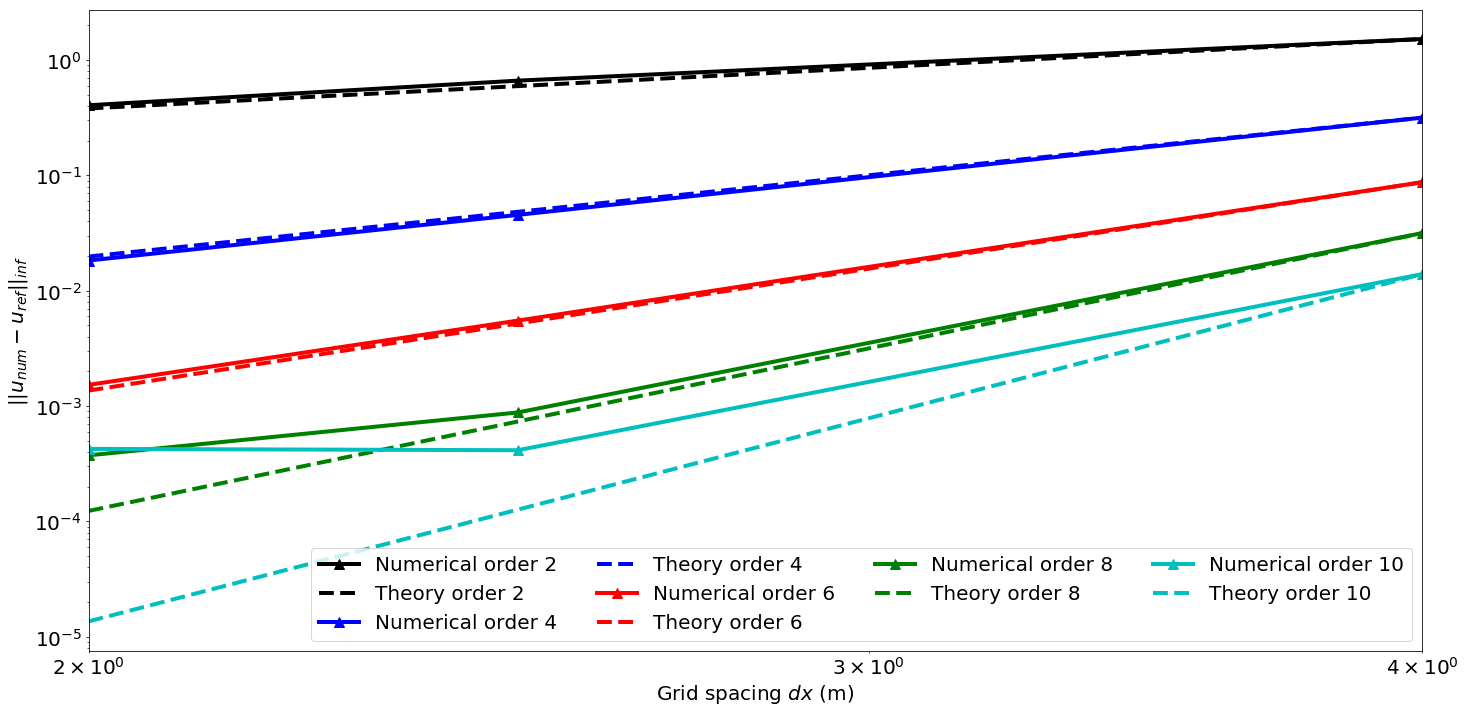

In [16]:
stylel = ('-^k', '-^b', '-^r', '-^g', '-^c')
style2 = ('--k', '--b', '--r', '--g', '--c')


plt.figure(figsize=(20, 10))
for i in range(0, 5):
    theory = [k**(orders[i]) for k in dx]
    theory = [errorl2[i, 2]*th/theory[2] for th in theory]
    plt.loglog([sc for sc in dx], errorl2[i, :], stylel[i], label=('Numerical order %s' % orders[i]),
               linewidth=4, markersize=10)
    plt.loglog([sc for sc in dx], theory, style2[i], label=('Theory order %s' % orders[i]),
               linewidth=4, markersize=10)
#     for x, y, a in zip([sc for sc in dx], errorl2[i, :], [('dx = %s m' % (sc)) for sc in dx]):
#                 plt.annotate(a, xy=(x, y), xytext=(4, 2),
#                              textcoords='offset points', size=20,
#                              horizontalalignment='left', verticalalignment='top')
plt.xlabel("Grid spacing $dx$ (m)", fontsize=20)
plt.ylabel("$||u_{num} - u_{ref}||_{inf}$", fontsize=20)
plt.tick_params(axis='both', which='both', labelsize=20)
plt.tight_layout()
plt.legend(fontsize=20, ncol=4, fancybox=True, loc='lower right')
plt.xlim((2.0, 4.0))
plt.savefig("Convergence.pdf", format='pdf', facecolor='white',
            orientation='landscape', bbox_inches='tight')
plt.show()